# 07. Рекомендательные системы

Содержание:
- Введение
- Пример с данными
- Классические подходы

# 1. Введение

**Рекомендательная система** $-$ это программа, которая пытается предсказать, какие объекты (товары, фильмы, музыка) будут интересны пользователю, анализируя информацию о его предпочтениях и поведении.

Простые примеры из жизни:
- Друг рекомендует фильм, потому что знает ваши вкусы
- Продавец в книжном магазине советует новинку на основе ваших предыдущих покупок
- В интернет-магазине вы видите блок "Люди также покупают"

Цели:
- Увеличение продаж/просмотров: Например, в интернет-магазинах рекомендации значительно повышают вероятность покупки
- Удержание пользователей: Персонализированные рекомендации увеличивают время, которое пользователи проводят в сервисе

![](https://www.nvidia.com/content/dam/en-zz/Solutions/glossary/data-science/recommendation-system/img-1.png)

[Источник: [nvidia.com](https://www.nvidia.com/en-us/glossary/recommendation-system/)]

## Основная задача

Формально задача рекомендательных систем формулируется так:
* для каждого пользователя $u$ и объекта $i$ необходимо оценить значение рейтинга $r_{ui}$ и выбрать несколько объектов с наибольшим рейтингом.

### Какие данные полезны?

#### Явная обратная связь (Explicit Feedback)
Это прямые оценки, которые пользователь сознательно ставит объектам:
- Рейтинги (1-5 звёзд)
- Лайки/дизлайки
- Текстовые отзывы

Такого фидбека очень мало, но он наиболее точно характеризует отношение пользователя к товару.

#### Неявная обратная связь (Implicit Feedback)
Это любая другая информация о действиях пользователя:
- Просмотры, клики
- Время на странице
- Покупки
- Факт дослушивания трека до конца

Обычно такого сигнала в разы больше, чем явного, однако он более шумный. На практике большинство систем работают именно с неявной обратной связью.

## Как оценивать рекомендации?

Offline-метрики:
- **Precision@k**: доля релевантных объектов среди первых $k$ рекомендованных
- **Recall@k**: доля найденных релевантных объектов (среди первых $k$ рекомендованных) от общего числа релевантных
- **MAP@k (Mean Average Precision)**: усреднённая точность по всем пользователям

Online-метрики:
- **CTR (Click-Through Rate)**: отношение числа кликов к числу показов
- **Conversion Rate**: доля пользователей, совершивших целевое действие
- **Время, проведённое в системе**

> - Offline-метрики = лабораторные испытания
> - Online-метрики = полевая эксплуатация

## Проблемы

### Разреженность данных

На примере рекомендации товаров пользователю: Матрица "пользователь-товар" в основном состоит из нулей.
Если представить данные как таблицу, где строки $-$ пользователи, столбцы $-$ товары, а значения $-$ оценки, то заполненных ячеек будет очень мало.

Например, в крупном сервисе могут быть миллионы пользователей и товаров, но каждый пользователь взаимодействовал лишь с десятками или сотнями объектов.

![](./res/08_sparse.jpg)

### Проблема холодного старта

- когда приходит новый пользователь, у которого ещё нет рейтингов, системе не на чем строить персонализированные рекомендации.
- Когда добавляется новый товар, у которого ещё нет оценок, система не может его рекомендовать.

> Как можно решить? Например, рекомендовать самые популярные товары. Как ещё?

### Фильтрация пузыря

Рекомендательная система, построенная исключительно на коллаборативной фильтрации (использвование поведения и предпочтения пользователей в прошлом для прогнозирования их будущих предпочтений), будет постепенно вгонять пользователя в информационный пузырь: эти методы не предполагают открытия новых интересов у пользователя, они способны только эксплуатировать уже имеющиеся.

- **Разнообразие** $-$ это способность модели рекомендовать разные по содержанию объекты. 
- **Интуитивная прозорливость** $-$ это способность рекомендовать такие объекты, которые не только не релевантны для пользователя, но ещё и существенно отличаются от того, с какими объектами пользователь взаимодействовал в прошлом.

# 2. Пример с данными

Для наших примеров мы будем использовать датасет с рейтингами фильмов (игрушечный аналог [movielens](https://grouplens.org/datasets/movielens/)).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD

# Генерация данных
def generate_movie_data():
    np.random.seed(42)
    
    # Создаем имитацию данных MovieLens
    users = [f'User{i}' for i in range(1, 6)]
    movies = ['The Matrix', 'Inception', 'Titanic', 'The Godfather', 'Pulp Fiction', 
              'Forrest Gump', 'The Dark Knight', 'Fight Club', 'The Shawshank Redemption', 'The Godfather II']
    
    # Создаем матрицу рейтингов (5 пользователей x 10 фильмов)
    ratings = np.zeros((len(users), len(movies)))
    
    # Заполняем некоторые оценки (имитируем разреженность)
    for i in range(len(users)):
        for j in range(len(movies)):
            if np.random.random() > 0.7:  # 30% заполненности
                ratings[i, j] = np.random.randint(1, 6)
    
    return users, movies, ratings

users, movies, ratings = generate_movie_data()
ratings_df = pd.DataFrame(ratings, index=users, columns=movies)
print("Матрица рейтингов:")
print(ratings_df)

Матрица рейтингов:
       The Matrix  Inception  Titanic  The Godfather  Pulp Fiction  \
User1         0.0        3.0      5.0            0.0           0.0   
User2         2.0        0.0      0.0            0.0           0.0   
User3         0.0        0.0      3.0            0.0           1.0   
User4         0.0        0.0      0.0            0.0           0.0   
User5         2.0        0.0      0.0            4.0           4.0   

       Forrest Gump  The Dark Knight  Fight Club  The Shawshank Redemption  \
User1           0.0              4.0         0.0                       0.0   
User2           0.0              0.0         0.0                       0.0   
User3           0.0              0.0         0.0                       0.0   
User4           0.0              0.0         3.0                       4.0   
User5           0.0              4.0         0.0                       0.0   

       The Godfather II  
User1               0.0  
User2               0.0  
User3        

## Визуализация  матрицы рейтингов

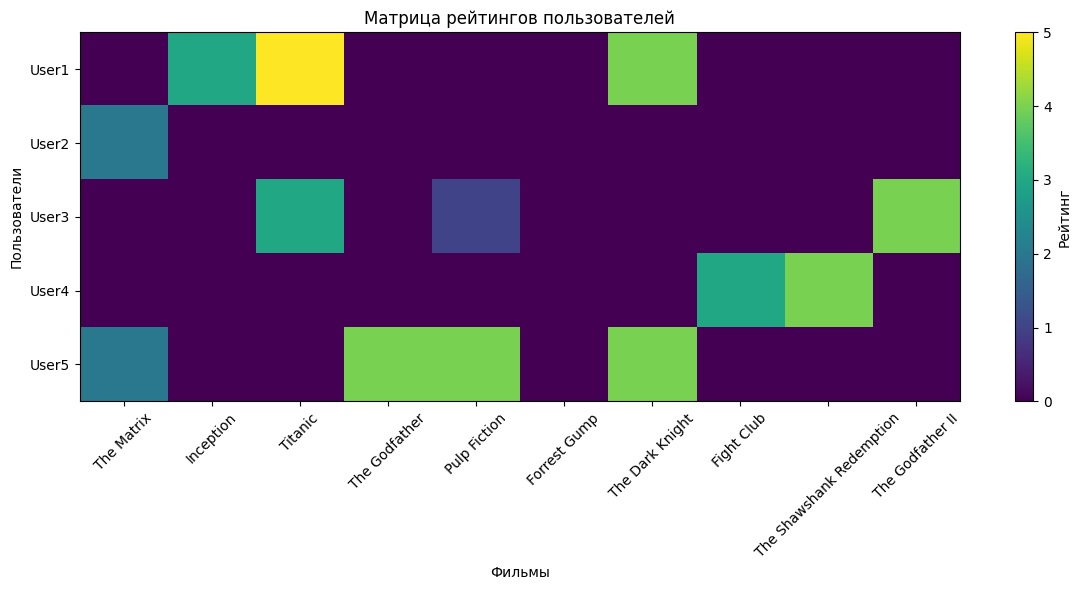

In [2]:
plt.figure(figsize=(12, 6))
plt.imshow(ratings, cmap='viridis', aspect='auto')
plt.colorbar(label='Рейтинг')
plt.xticks(range(len(movies)), movies, rotation=45)
plt.yticks(range(len(users)), users)
plt.title('Матрица рейтингов пользователей')
plt.xlabel('Фильмы')
plt.ylabel('Пользователи')
plt.tight_layout()
plt.show()

## Визуализация распределения рейтингов

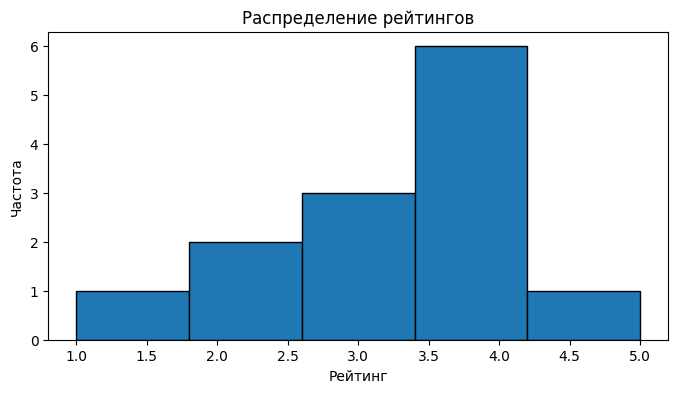

In [3]:
flat_ratings = ratings[ratings > 0]
plt.figure(figsize=(8, 4))
plt.hist(flat_ratings, bins=5, edgecolor='black')
plt.title('Распределение рейтингов')
plt.xlabel('Рейтинг')
plt.ylabel('Частота')
plt.show()

# 3. Классические подходы

## Коллаборативная фильтрация (Collaborative Filtering)

> Идея: "Скажи мне, кто твой друг, и я скажу, кто ты". В контексте рекомендаций: "похожим пользователям нравятся похожие объекты".

### User-Based CF

Находим похожих пользователей и рекомендуем то, что понравилось им.

In [4]:
def user_based_cf(ratings_df, target_user, k=2):
    """
    User-Based Collaborative Filtering
    
    :param ratings_df: DataFrame с рейтингами
    :param target_user: индекс целевого пользователя
    :param k: количество похожих пользователей
    """
    # Заменяем нули на NaN для корректного расчета косинусной меры
    ratings_filled = ratings_df.replace(0, np.nan)
    
    # Вычисляем попарные косинусные similarity между пользователями
    user_similarity = cosine_similarity(ratings_filled.fillna(0))
    user_similarity_df = pd.DataFrame(user_similarity, 
                                     index=ratings_df.index, 
                                     columns=ratings_df.index)
    
    print("Матрица схожести пользователей:")
    print(user_similarity_df.round(3))
    
    # Находим k самых похожих пользователей (исключая самого пользователя)
    similar_users = user_similarity_df[target_user].sort_values(ascending=False)[1:k+1]
    print(f"\nСамые похожие пользователи на {target_user}: {similar_users.index.tolist()}")
    
    # Предсказываем оценки для непросмотренных фильмов
    target_ratings = ratings_df.loc[target_user]
    unseen_movies = target_ratings[target_ratings == 0].index
    
    predictions = {}
    for movie in unseen_movies:
        # Взвешенное среднее по похожим пользователям
        weighted_sum = 0
        similarity_sum = 0
        
        for user, similarity in similar_users.items():
            user_rating = ratings_df.loc[user, movie]
            if user_rating > 0:
                weighted_sum += similarity * user_rating
                similarity_sum += similarity
        
        if similarity_sum > 0:
            predictions[movie] = weighted_sum / similarity_sum
    
    # Сортируем предсказания по убыванию рейтинга
    sorted_predictions = sorted(predictions.items(), key=lambda x: x[1], reverse=True)
    
    print(f"\nРекомендации для {target_user}:")
    for movie, rating in sorted_predictions[:3]:
        print(f"- {movie}: {rating:.2f}")
    
    return sorted_predictions

#### Пример использования

In [5]:
recommendations = user_based_cf(ratings_df, 'User1')

Матрица схожести пользователей:
       User1  User2  User3  User4  User5
User1  1.000  0.000  0.416    0.0  0.314
User2  0.000  1.000  0.000    0.0  0.277
User3  0.416  0.000  1.000    0.0  0.109
User4  0.000  0.000  0.000    1.0  0.000
User5  0.314  0.277  0.109    0.0  1.000

Самые похожие пользователи на User1: ['User3', 'User5']

Рекомендации для User1:
- The Godfather: 4.00
- The Godfather II: 4.00
- Pulp Fiction: 2.29


### Item-Based CF

Находим похожие товары и рекомендуем их. Этот подход более стабилен во времени, так как сходство товаров меняется медленнее, чем сходство пользователей.

In [6]:
def item_based_cf(ratings_df, target_user, k=2):
    """
    Item-Based Collaborative Filtering
    
    :param ratings_df: DataFrame с рейтингами
    :param target_user: индекс целевого пользователя
    :param k: количество похожих товаров
    """
    # Транспонируем матрицу для вычисления схожести товаров
    item_similarity = cosine_similarity(ratings_df.T)
    item_similarity_df = pd.DataFrame(item_similarity, 
                                     index=ratings_df.columns, 
                                     columns=ratings_df.columns)
    
    print("Матрица схожести товаров (первые 5x5):")
    print(item_similarity_df.iloc[:5, :5].round(3))
    
    # Для целевого пользователя находим непросмотренные фильмы
    target_ratings = ratings_df.loc[target_user]
    rated_movies = target_ratings[target_ratings > 0].index
    unseen_movies = target_ratings[target_ratings == 0].index
    
    predictions = {}
    for unseen_movie in unseen_movies:
        weighted_sum = 0
        similarity_sum = 0
        
        # Для каждого просмотренного фильма находим схожесть с непросмотренным
        for rated_movie in rated_movies:
            similarity = item_similarity_df.loc[rated_movie, unseen_movie]
            if similarity > 0:
                weighted_sum += similarity * ratings_df.loc[target_user, rated_movie]
                similarity_sum += similarity
        
        if similarity_sum > 0:
            predictions[unseen_movie] = weighted_sum / similarity_sum
    
    # Сортируем предсказания по убыванию рейтинга
    sorted_predictions = sorted(predictions.items(), key=lambda x: x[1], reverse=True)
    
    print(f"\nРекомендации для {target_user} (item-based):")
    for movie, rating in sorted_predictions[:3]:
        print(f"- {movie}: {rating:.2f}")
    
    return sorted_predictions

#### Пример использования

In [7]:
item_recommendations = item_based_cf(ratings_df, 'User1')

Матрица схожести товаров (первые 5x5):
               The Matrix  Inception  Titanic  The Godfather  Pulp Fiction
The Matrix          1.000      0.000    0.000          0.707         0.686
Inception           0.000      1.000    0.857          0.000         0.000
Titanic             0.000      0.857    1.000          0.000         0.125
The Godfather       0.707      0.000    0.000          1.000         0.970
Pulp Fiction        0.686      0.000    0.125          0.970         1.000

Рекомендации для User1 (item-based):
- The Godfather II: 5.00
- Pulp Fiction: 4.15
- The Matrix: 4.00


### Плюсы/Минусы коллаборативной фильтрации

**Плюсы**:
- Не нужно знать о свойствах товаров (content-agnostic)
- Способен находить неочевидные связи

**Минусы**:
- "Холодный старт" для новых пользователей и товаров
- Проблема разреженности
- Может создавать "информационный пузырь"

## Контентная фильтрация (Content-Based Filtering)

> Идея: "Рекомендуй то, что похоже на то, что уже понравилось". В отличие от коллаборативной фильтрации, этот подход не использует данные других пользователей.

![](./res/07_recsys.png)

[Источник: [hub.forklog.com](https://hub.forklog.com/rekomendatelnye-sistemy-kak-algoritmy-podbirayut-nam-tovary-i-kontent/)]

In [8]:
def content_based_filtering(movie_features, user_profile, movie_titles, top_k=3):
    """
    Content-Based Filtering
    
    :param movie_features: матрица признаков фильмов
    :param user_profile: вектор предпочтений пользователя
    :param movie_titles: названия фильмов
    :param top_k: количество рекомендаций
    """
    # Вычисляем косинусную схожесть между профилем пользователя и фильмами
    similarities = cosine_similarity(user_profile.reshape(1, -1), movie_features)
    
    # Сортируем по убыванию схожести
    similar_indices = similarities.argsort()[0][::-1]
    
    print("Рекомендации (content-based):")
    for i in range(top_k):
        idx = similar_indices[i]
        print(f"{i+1}. {movie_titles[idx]} (схожесть: {similarities[0, idx]:.3f})")
    
    return similar_indices[:top_k]

#### Пример создания признаков фильмов (жанры: action, drama, romance, sci-fi, crime)

In [9]:
movie_features = np.array([
    [1, 0, 0, 1, 0],  # The Matrix (action, sci-fi)
    [1, 0, 0, 1, 0],  # Inception (action, sci-fi)
    [0, 1, 1, 0, 0],  # Titanic (drama, romance)
    [0, 1, 0, 0, 1],  # The Godfather (drama, crime)
    [0, 1, 0, 0, 1],  # Pulp Fiction (drama, crime)
    [0, 1, 1, 0, 0],  # Forrest Gump (drama, romance)
    [1, 1, 0, 0, 0],  # The Dark Knight (action, drama)
    [1, 1, 0, 0, 0],  # Fight Club (action, drama)
    [0, 1, 0, 0, 0],  # The Shawshank Redemption (drama)
    [0, 1, 0, 0, 1]   # The Godfather II (drama, crime)
])

#### Профиль пользователя (нравится action и sci-fi)

In [10]:
user_profile = np.array([1, 0, 0, 1, 0])

#### Получаем рекомендации

In [11]:
content_recommendations = content_based_filtering(movie_features, user_profile, movies)

Рекомендации (content-based):
1. Inception (схожесть: 1.000)
2. The Matrix (схожесть: 1.000)
3. Fight Club (схожесть: 0.500)


#### Плюсы/Минусы контентной фильтрации

**Плюсы**:
- Решает проблему "холодного старта" для новых товаров
- Не зависит от данных других пользователей
- Прозрачность рекомендаций (можно объяснить, почему рекомендован объект)

**Минусы**:
- Ограниченность рекомендаций (нет serendipity — "счастливой случайности")
- Требуется много метаданных об объектах
- Не может находить неочевидные межпредметные связи